# SWAN Pre-Processing and Grid Preparation
This notebook walks through the workflow of preparing bathymetry, generating SWAN-compatible grids, and visualizing the data.



## # 1. Import Required Libraries


In [7]:
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import cmocean
from rasterio.plot import plotting_extent
import numpy as np
import pandas as pd

## # 2. Bathymetry Preparation
- Read the bathymetry GeoTIFF
- Visualize the bathymetry with wave and target locations
- Prepare the bathymetry for SWAN (.dep file)

In [8]:
# Read the bathymetry raster
with rasterio.open('../02_Bathymetry/DTM_lecture.tif') as src:
    Bathy = src.read(1)
    Bathy_extent = plotting_extent(src)
    crs = src.crs
    transform = src.transform
    print("CRS:", crs)

# Read point locations from CSV
WaveLoc = pd.read_csv('../03_GIS/Wave_Locations.csv')
Locations = pd.read_csv('../03_GIS/Target_Locations.csv')

# Convert depths to positive downward values
Bathy = -1 * Bathy

# Prepare bathymetry for SWAN
Bathy[Bathy < 0.10] = -9999
bathy_swan = np.flipud(Bathy)
np.savetxt("../02_Bathymetry/bathymetry_swan.dep", Bathy, fmt="%.2f")

# Extract metadata for INPGRID
ny, nx = Bathy.shape
dx = transform.a
dy = -transform.e
x0 = Bathy_extent[0]
y0 = Bathy_extent[2]
alph0 = 0.0

print(f"INPGRID BOTTOM {x0:.2f} {y0:.2f} {alph0:.1f} {nx} {ny} {dx:.2f} {dy:.2f} EXC -9999.")

CRS: EPSG:25832
INPGRID BOTTOM 701560.77 4803432.30 0.0 3887 3289 98.04 98.05 EXC -9999.


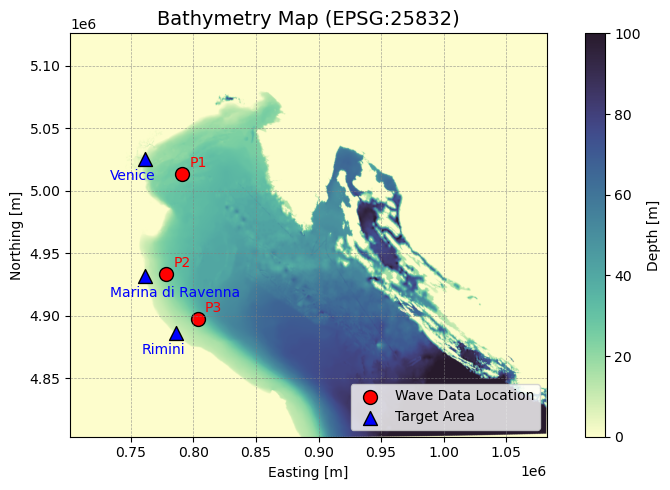

In [9]:
# Visualization 
fig, ax = plt.subplots(figsize=(8, 5))

raster_plot = ax.imshow(Bathy, extent=Bathy_extent, cmap=cmocean.cm.deep,
                        vmin=0, vmax=100, origin='upper')
cbar = plt.colorbar(raster_plot, ax=ax, label='Depth [m]')

plt.scatter(WaveLoc["X"], WaveLoc["Y"], s=100, color='red', marker='o', 
            edgecolor='black', label='Wave Data Location')
plt.scatter(Locations["X"], Locations["Y"], s=100, color='blue', marker='^', 
            edgecolor='black', label='Target Area')

for idx, row in WaveLoc.iterrows():
    ax.annotate(row["Id"], xy=(row["X"], row["Y"]),
                xytext=(5, 5), textcoords="offset points", 
                fontsize=10, color='red')

for idx, row in Locations.iterrows():
    ax.annotate(row["Name"], xy=(row["X"], row["Y"]),
                xytext=(-25, -15), textcoords="offset points",
                fontsize=10, color='blue')

ax.set_title('Bathymetry Map (EPSG:25832)', fontsize=14)
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()

## # 3. Grid Generation for SWAN
- Create a regular grid
- Visualize the grid over the bathymetry
- Define output features

In [25]:
# Define grid parameters
xlenc = 30000.0
ylenc = 17500.0

x0 = 779500
y0 = 4917000

mxc = int(xlenc / 100)
myc = int(ylenc / 100)
alph0_deg = 95

# Define output parameters 
# *** Point *** 
# POINts ’snamep’ [xp] [yp]
snamep1 = 'P1'   # Name 
xp1     = 762500.0  # x coordinate 
yp1     = 4932000.0 # y coordinate 

snamep2 = 'P2'   # Name 
xp2     = 765000.0  # x coordinate 
yp2     = 4933000.0 # y coordinate 

# *** Curve *** 
# CURve ’snamec’ [xc0] [yc0] < [intc] [xc1] [yc1] >
snamec = 'T1'
xc0    = 778245.0
yc0    = 4933370.0
xc1    = 761192
yc1    = 4931934
intc   = 200

print(WaveLoc)
print(Locations)


   Id  latitude  longitude       X        Y  Depht
0  P1      45.0       13.0  791027  5013796   27.0
1  P2      44.5       12.5  778245  4933370   24.0
2  P3      44.0       13.0  803411  4897322   25.0
   id               Name       X        Y
0   1             Rimini  786216  4886340
1   2  Marina di Ravenna  761192  4931934
2   3             Venice  761153  5025309


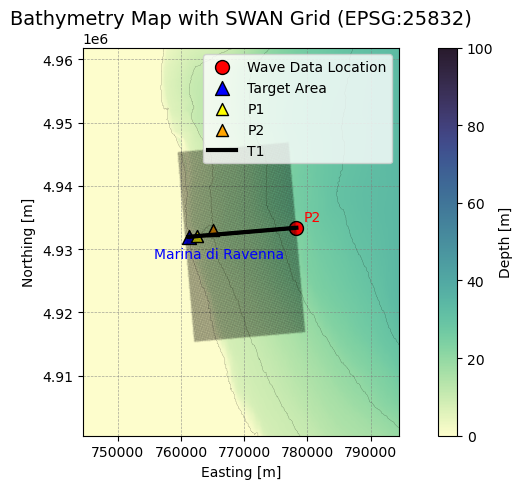

In [26]:
# Grid resolution 
dx = xlenc / (mxc - 1)
dy = ylenc / (myc - 1)

# Create meshgrid
x = np.linspace(x0, x0 + xlenc, mxc)
y = np.linspace(y0, y0 + ylenc, myc)
X, Y = np.meshgrid(x, y)

# Apply rotation
alph0_rad = np.deg2rad(alph0_deg)
cos_a, sin_a = np.cos(alph0_rad), np.sin(alph0_rad)
X_rot = cos_a * (X - x0) - sin_a * (Y - y0) + x0
Y_rot = sin_a * (X - x0) + cos_a * (Y - y0) + y0

# Visualize rotated grid
fig, ax = plt.subplots(figsize=(8, 5))
raster_plot = ax.imshow(Bathy, extent=Bathy_extent, cmap=cmocean.cm.deep,
                        vmin=0, vmax=100, origin='upper')
cbar = plt.colorbar(raster_plot, ax=ax, label='Depth [m]')

contours = ax.contour(
    np.linspace(Bathy_extent[0], Bathy_extent[1], Bathy.shape[1]),
    np.linspace(Bathy_extent[3], Bathy_extent[2], Bathy.shape[0]),
    Bathy, 
    levels=np.arange(0, 100, 10),  # Contour every 5 meters
    colors='black', 
    linewidths=0.1
)
ax.clabel(contours, inline=True, fontsize=5, fmt='%1.0f m')  # Label the contours

plt.scatter(WaveLoc["X"], WaveLoc["Y"], s=100, color='red', marker='o', 
            edgecolor='black', label='Wave Data Location')
plt.scatter(Locations["X"], Locations["Y"], s=100, color='blue', marker='^', 
            edgecolor='black', label='Target Area')

plt.scatter(xp1, yp1, s=75, color='yellow', marker='^', 
            edgecolor='black', label= snamep1)
plt.scatter(xp2, yp2, s=75, color='orange', marker='^', 
            edgecolor='black', label= snamep2)
ax.plot((xc0,xc1), (yc0,yc1), 'k', linewidth=3, label=snamec)

for idx, row in WaveLoc.iterrows():
    ax.annotate(row["Id"], xy=(row["X"], row["Y"]), xytext=(5, 5), textcoords="offset points", fontsize=10, color='red')

for idx, row in Locations.iterrows():
    ax.annotate(row["Name"], xy=(row["X"], row["Y"]), xytext=(-25, -15), textcoords="offset points", fontsize=10, color='blue')

plt.plot(X_rot, Y_rot, 'k.', markersize=1,linewidth = 0.1, alpha = 0.05)
margin = 15000  # meters
ax.set_xlim(X_rot.min() - margin, X_rot.max() + margin)
ax.set_ylim(Y_rot.min() - margin, Y_rot.max() + margin)
ax.set_title('Bathymetry Map with SWAN Grid (EPSG:25832)', fontsize=14)
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [27]:
# Print SWAN CGRID command
print("SWAN CGRID command:")
print(f"CGRID {x0:.0f} {y0:.0f} {alph0_deg:.1f} {xlenc:.1f} {ylenc:.1f} {mxc-1} {myc-1} CIRcle 36 0.03 1.0 50")
print('GRID Resolution:','dx =', dx ,'m ', 'and dy =', dy ,'m ')
print(" ")
print("SWAN POINts command:")
print(f"POINts {snamep2} {xp2:.1f} {yp2:.1f}")
print(" ")

print(f"POINts {snamep1} {xp1:.1f} {yp1:.1f}")
print(" ")

print("SWAN CURve command:")
print(f"CURve {snamec} {xc0:.1f} {yc0:.1f} {intc:.0f} {xc1:.1f} {yc1:.1f}")
print(" ")


SWAN CGRID command:
CGRID 779500 4917000 95.0 30000.0 17500.0 299 174 CIRcle 36 0.03 1.0 50
GRID Resolution: dx = 100.33444816053512 m  and dy = 100.57471264367815 m 
 
SWAN POINts command:
POINts P2 765000.0 4933000.0
 
POINts P1 762500.0 4932000.0
 
SWAN CURve command:
CURve T1 778245.0 4933370.0 200 761192.0 4931934.0
 


copy these commands into the swan file
